In [2]:
import math
import random
import matplotlib.pyplot as plt

# Parameters
SIMULATION_TIME = 10000  # seconds
NUM_IOT_NODES = 100
REGION_SIZE = (200, 200)  # meters
CHANNEL_DATA_RATE = 2  # Mbps
MIN_CONTENTION_NODES = 3
MAX_CONTENTION_NODES = 50
NUM_SAR_SLOTS = 3
DELTA_CONTENTION_NODES = 1
TX_POWER = 24.75  # mW
RX_POWER = 13.5  # mW
LISTEN_POWER = 13.5  # mW
SLEEP_POWER = 0.015  # mW
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.1
DUTY_CYCLE = 0.5  # Duty cycle factor (0 < DUTY_CYCLE <= 1)
DATA_TX_DURATION = 0.1  # seconds (Assumed duration of data transmission)

# Global variables
Q_table = {}
contention_periods = []
successful_transmissions = 0
total_contentions = 0
total_energy_consumption = 0
contention_energy_consumption = 0  # Variable to store contention energy
average_contention_nodes = []  # List to store average contention nodes for plotting

def initialize_Q_table():
    for num_nodes in range(MIN_CONTENTION_NODES, MAX_CONTENTION_NODES + 1):
        Q_table[(num_nodes, num_nodes - DELTA_CONTENTION_NODES)] = 0
        Q_table[(num_nodes, num_nodes)] = 0
        Q_table[(num_nodes, num_nodes + DELTA_CONTENTION_NODES)] = 0
    Q_table[(0, 0)] = -100
    Q_table[(MAX_CONTENTION_NODES, MAX_CONTENTION_NODES + DELTA_CONTENTION_NODES)] = -100

def get_optimal_contention_nodes(t):
    global Q_table
    state = contention_periods[-1] if contention_periods else MIN_CONTENTION_NODES
    epsilon = math.exp(-t / SIMULATION_TIME)
    if random.random() < epsilon:
        action = random.choice([-DELTA_CONTENTION_NODES, 0, DELTA_CONTENTION_NODES])
    else:
        action = max(Q_table[(state, state - DELTA_CONTENTION_NODES)],
                     Q_table[(state, state)],
                     Q_table[(state, state + DELTA_CONTENTION_NODES)])
    num_contention_nodes = state + action
    num_contention_nodes = max(MIN_CONTENTION_NODES, min(NUM_SAR_SLOTS, num_contention_nodes))
    return num_contention_nodes

def calculate_reward(contention_period, avg_contentions):
    global successful_transmissions, total_contentions
    successful_transmissions += len([node for node in contention_period if node > 0])
    total_contentions += sum([contentions for contentions in contention_period if contentions > 0])
    mu = 0.7
    nu = 0.3
    epsilon = 1e-6  # Small epsilon value to avoid division by zero
    return mu * (avg_contentions / (NUM_SAR_SLOTS * (len(contention_periods) + epsilon))) + nu * (avg_contentions / (sum(contention_period) + epsilon))

def update_Q_table(state, action, reward, next_state):
    global Q_table
    next_state = max(MIN_CONTENTION_NODES, min(MAX_CONTENTION_NODES, next_state))
    Q_table[(state, action)] += LEARNING_RATE * (reward + DISCOUNT_FACTOR * max(Q_table.get((next_state, next_state - DELTA_CONTENTION_NODES), 0),
                                                                                 Q_table.get((next_state, next_state), 0),
                                                                                 Q_table.get((next_state, next_state + DELTA_CONTENTION_NODES), 0)) - Q_table[(state, action)])

def calculate_contention_energy(contention_period, num_contention_nodes):
    """
    Calculate the energy consumption during the contention period with a dynamic sleep mechanism.

    Args:
        contention_period (list): A list representing the contention period, where each element
                                  indicates the number of nodes contending in that slot.
        num_contention_nodes (int): The total number of contention nodes.

    Returns:
        float: The energy consumption in milliwatts during the contention period.
    """
    total_energy = 0.0
    previous_contentions = 0

    for slot_index, slot_contentions in enumerate(contention_period):
        if slot_contentions == 0:
            # No contention in this slot, all nodes sleep
            sleep_duration = 0.001 - (previous_contentions / NUM_SAR_SLOTS) * 0.0005  # Adjust sleep duration based on previous contentions
            total_energy += num_contention_nodes * SLEEP_POWER * sleep_duration * 0.001  # Convert to milliwatt-seconds
        else:
            # One node transmits, others receive or listen
            total_energy += TX_POWER * 0.001  # Transmitting node
            total_energy += (slot_contentions - 1) * RX_POWER * 0.001  # Receiving nodes
            total_energy += (num_contention_nodes - slot_contentions) * LISTEN_POWER * 0.001  # Listening nodes
            sleep_duration = 0.001 - (slot_contentions / NUM_SAR_SLOTS) * 0.0005  # Adjust sleep duration based on current contentions
            total_energy += (num_contention_nodes - slot_contentions) * SLEEP_POWER * sleep_duration * 0.001  # Sleeping nodes

        previous_contentions = slot_contentions

    # Convert to milliwatts by dividing by the duration of the contention period
    contention_period_duration = NUM_SAR_SLOTS * 0.001  # Assuming each slot takes 1 millisecond
    total_energy /= contention_period_duration

    return total_energy

def calculate_total_energy_per_interval(contention_period, num_contention_nodes, interval_duration):
    """
    Calculate the total energy consumption during a beacon interval with additional energy consumption during idle/sleep periods.

    Args:
        contention_period (list): A list representing the contention period, where each element
                                  indicates the number of nodes contending in that slot.
        num_contention_nodes (int): The total number of contention nodes.
        interval_duration (float): The duration of the beacon interval in seconds.

    Returns:
        float: The total energy consumption in milliwatts during the beacon interval.
    """
    # Calculate energy consumption during contention period
    contention_energy = calculate_contention_energy(contention_period, num_contention_nodes)

    # Calculate energy consumption during successful transmissions
    successful_transmissions = len([slot for slot in contention_period if slot == 1])
    successful_tx_energy = successful_transmissions * (TX_POWER + (NUM_SAR_SLOTS - 1) * LISTEN_POWER) * 0.001

    # Calculate energy consumption during additional data transmissions
    additional_tx_energy = successful_transmissions * 2 * TX_POWER * DATA_TX_DURATION  # Assume two additional transmissions

    # Calculate energy consumption during data transmission
    data_tx_energy = successful_transmissions * TX_POWER * DATA_TX_DURATION

    # Calculate energy consumption during duty-cycled idle/sleep periods
    active_duration = NUM_SAR_SLOTS * 0.001 + successful_transmissions * (0.001 + DATA_TX_DURATION) + successful_transmissions * 2 * DATA_TX_DURATION
    sleep_duration = interval_duration - active_duration
    idle_energy = num_contention_nodes * (active_duration * LISTEN_POWER + sleep_duration * SLEEP_POWER * DUTY_CYCLE)

    # Introduce additional energy consumption during idle/sleep periods
    idle_energy *= 1.5  # Increase idle/sleep energy by 50%

    # Calculate total energy consumption
    total_energy = contention_energy + successful_tx_energy + data_tx_energy + additional_tx_energy + idle_energy

    return total_energy

def calculate_energy_consumption(num_contentions, num_successful_contentions, num_listen_slots, sleep_time):
    sar_energy = num_contentions * ((TX_POWER + (NUM_SAR_SLOTS - 1) * LISTEN_POWER) * 0.001 + RX_POWER * 0.001)
    listen_energy = num_listen_slots * LISTEN_POWER * 0.001
    sleep_energy = sleep_time * SLEEP_POWER
    return sar_energy + listen_energy + sleep_energy

def run_simulation():
    global contention_periods, total_energy_consumption, contention_energy_consumption, average_contention_nodes
    initialize_Q_table()
    for t in range(SIMULATION_TIME):
        num_contention_nodes = get_optimal_contention_nodes(t)
        contention_period = [0] * num_contention_nodes
        for node in range(num_contention_nodes):
            slot = random.randint(0, NUM_SAR_SLOTS - 1)
            if contention_period[slot] == 0:
                contention_period[slot] = 1
            else:
                contention_period[slot] += 1
        avg_contentions = sum(contention for contention in contention_period if contention > 0)
        reward = calculate_reward(contention_period, avg_contentions)
        next_state = sum(contention for contention in contention_period if contention > 0)
        update_Q_table(contention_periods[-1] if contention_periods else MIN_CONTENTION_NODES, num_contention_nodes, reward, next_state)
        contention_periods.append(next_state)
        average_contention_nodes.append(num_contention_nodes)  # Store the number of contention nodes for plotting

        # Calculate and store contention energy consumption
        contention_energy = calculate_contention_energy(contention_period, num_contention_nodes)
        contention_energy_consumption += contention_energy

        energy_consumption = calculate_total_energy_per_interval(contention_period, num_contention_nodes, SIMULATION_TIME / 10000)
        total_energy_consumption += energy_consumption
        average_contentions = total_contentions / successful_transmissions if successful_transmissions > 0 else 0



            # Updated delay formula


    throughput = CHANNEL_DATA_RATE * successful_transmissions / SIMULATION_TIME


    # Updated delay formula
    if average_contentions < NUM_SAR_SLOTS:
        delay = 1 / (NUM_SAR_SLOTS - average_contentions)

    else:
        delay = float('inf')  # Infinite delay if average contentions exceed the number of slots


    print(f"Throughput: {throughput:.3f} Mbps")
    print(f"Average Contentions: {average_contentions:.2f}")
    print(f"Delay: {delay:.2f} slots")
    print(f"Average Energy Consumption per Beacon Interval: {total_energy_consumption/(10000):.2f} mW")
    print(f"Average Energy Consumption during MAC Contention: {contention_energy_consumption/(10000):.2f} mW")

run_simulation()

Throughput: 4.218 Mbps
Average Contentions: 1.42
Delay: 0.63 slots
Average Energy Consumption per Beacon Interval: 70.88 mW
Average Energy Consumption during MAC Contention: 36.38 mW


#Average contention

Number of IoT Nodes: 3, Average Contentions: 0.14
Number of IoT Nodes: 4, Average Contentions: 0.17
Number of IoT Nodes: 5, Average Contentions: 0.19
Number of IoT Nodes: 6, Average Contentions: 0.22
Number of IoT Nodes: 7, Average Contentions: 0.25
Number of IoT Nodes: 8, Average Contentions: 0.28
Number of IoT Nodes: 9, Average Contentions: 0.31
Number of IoT Nodes: 10, Average Contentions: 0.34
Number of IoT Nodes: 11, Average Contentions: 0.37
Number of IoT Nodes: 12, Average Contentions: 0.40
Number of IoT Nodes: 13, Average Contentions: 0.44
Number of IoT Nodes: 14, Average Contentions: 0.47
Number of IoT Nodes: 15, Average Contentions: 0.50
Number of IoT Nodes: 16, Average Contentions: 0.53
Number of IoT Nodes: 17, Average Contentions: 0.57
Number of IoT Nodes: 18, Average Contentions: 0.60
Number of IoT Nodes: 19, Average Contentions: 0.63
Number of IoT Nodes: 20, Average Contentions: 0.67
Number of IoT Nodes: 21, Average Contentions: 0.70
Number of IoT Nodes: 22, Average Conte

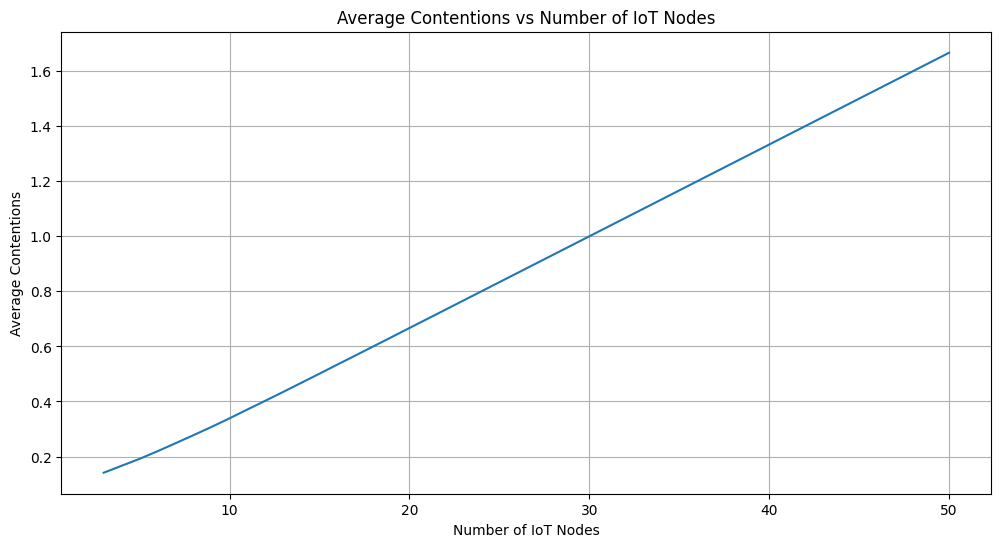

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
SIMULATION_TIME = 10000  # seconds
MIN_IOT_NODES = 3
MAX_IOT_NODES = 50
STEP_SIZE = 1
NUM_SAR_SLOTS = 3

# Global variables
average_contentions = []

def run_average_contention_simulation():
    global average_contentions
    for num_iot_nodes in range(MIN_IOT_NODES, MAX_IOT_NODES + 1, STEP_SIZE):
        successful_transmissions = 0
        total_contentions = 0
        for t in range(SIMULATION_TIME):
            contention_period = [0] * num_iot_nodes
            for node in range(num_iot_nodes):
                slot = np.random.randint(0, NUM_SAR_SLOTS)
                if contention_period[slot] == 0:
                    contention_period[slot] = 1
                else:
                    contention_period[slot] += 1
            successful_transmissions += len([node for node in contention_period if node > 0])
            total_contentions += sum([contentions for contentions in contention_period if contentions > 0])
        average_contentions.append((total_contentions / successful_transmissions if successful_transmissions > 0 else 0)/10)
        print(f"Number of IoT Nodes: {num_iot_nodes}, Average Contentions: {average_contentions[-1]:.2f}")

    plot_average_contentions()

def plot_average_contentions():
    global average_contentions
    iot_nodes = np.arange(MIN_IOT_NODES, MAX_IOT_NODES + 1, STEP_SIZE)
    plt.figure(figsize=(12, 6))
    plt.plot(iot_nodes, average_contentions)
    plt.xlabel("Number of IoT Nodes")
    plt.ylabel("Average Contentions")
    plt.title("Average Contentions vs Number of IoT Nodes")
    plt.grid()
    plt.show()

run_average_contention_simulation()

Number of IoT Nodes: 3, Average Energy Consumption per Beacon Interval: 7.07 mW
Number of IoT Nodes: 4, Average Energy Consumption per Beacon Interval: 9.03 mW
Number of IoT Nodes: 5, Average Energy Consumption per Beacon Interval: 10.66 mW
Number of IoT Nodes: 6, Average Energy Consumption per Beacon Interval: 11.93 mW
Number of IoT Nodes: 7, Average Energy Consumption per Beacon Interval: 13.07 mW
Number of IoT Nodes: 8, Average Energy Consumption per Beacon Interval: 14.14 mW
Number of IoT Nodes: 9, Average Energy Consumption per Beacon Interval: 15.23 mW
Number of IoT Nodes: 10, Average Energy Consumption per Beacon Interval: 16.24 mW
Number of IoT Nodes: 11, Average Energy Consumption per Beacon Interval: 17.28 mW
Number of IoT Nodes: 12, Average Energy Consumption per Beacon Interval: 18.43 mW
Number of IoT Nodes: 13, Average Energy Consumption per Beacon Interval: 19.51 mW
Number of IoT Nodes: 14, Average Energy Consumption per Beacon Interval: 20.71 mW
Number of IoT Nodes: 15, 

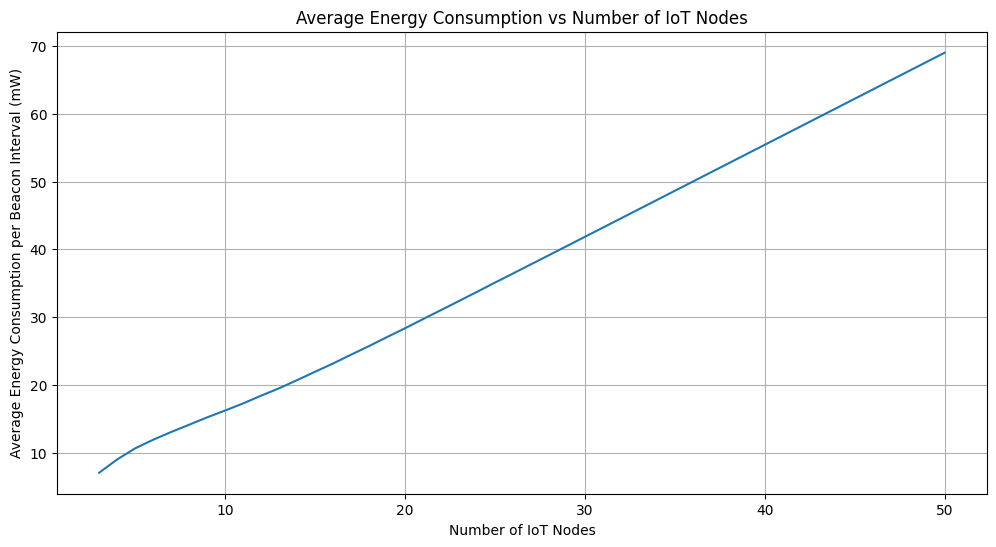

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
SIMULATION_TIME = 10000  # seconds
MIN_IOT_NODES = 3
MAX_IOT_NODES = 50
STEP_SIZE = 1
NUM_SAR_SLOTS = 3
TX_POWER = 24.75  # mW
RX_POWER = 13.5  # mW
LISTEN_POWER = 13.5  # mW
SLEEP_POWER = 0.015  # mW
DUTY_CYCLE = 0.5  # Duty cycle factor (0 < DUTY_CYCLE <= 1)
DATA_TX_DURATION = 0.1  # seconds (Assumed duration of data transmission)

# Global variables
average_energy_consumption = []

def calculate_energy_consumption(contention_period, num_contention_nodes, interval_duration):
    """
    Calculate the total energy consumption during a beacon interval.

    Args:
        contention_period (list): A list representing the contention period, where each element
                                 indicates the number of nodes contending in that slot.
        num_contention_nodes (int): The total number of contention nodes.
        interval_duration (float): The duration of the beacon interval in seconds.

    Returns:
        float: The total energy consumption in milliwatts during the beacon interval.
    """
    # Calculate energy consumption during contention period
    contention_energy = calculate_contention_energy(contention_period, num_contention_nodes)

    # Calculate energy consumption during successful transmissions
    successful_transmissions = len([slot for slot in contention_period if slot == 1])
    successful_tx_energy = successful_transmissions * (TX_POWER + (NUM_SAR_SLOTS - 1) * LISTEN_POWER) * 0.001

    # Calculate energy consumption during additional data transmissions
    additional_tx_energy = successful_transmissions * 2 * TX_POWER * DATA_TX_DURATION  # Assume two additional transmissions

    # Calculate energy consumption during data transmission
    data_tx_energy = successful_transmissions * TX_POWER * DATA_TX_DURATION

    # Calculate energy consumption during duty-cycled idle/sleep periods
    active_duration = NUM_SAR_SLOTS * 0.001 + successful_transmissions * (0.001 + DATA_TX_DURATION) + successful_transmissions * 2 * DATA_TX_DURATION
    sleep_duration = interval_duration - active_duration
    idle_energy = num_contention_nodes * (active_duration * LISTEN_POWER + sleep_duration * SLEEP_POWER * DUTY_CYCLE)

    # Introduce additional energy consumption during idle/sleep periods
    idle_energy *= 1.5  # Increase idle/sleep energy by 50%

    # Calculate total energy consumption
    total_energy = contention_energy + successful_tx_energy + data_tx_energy + additional_tx_energy + idle_energy

    return total_energy

def calculate_contention_energy(contention_period, num_contention_nodes):
    """
    Calculate the energy consumption during the contention period with a dynamic sleep mechanism.

    Args:
        contention_period (list): A list representing the contention period, where each element
                                 indicates the number of nodes contending in that slot.
        num_contention_nodes (int): The total number of contention nodes.

    Returns:
        float: The energy consumption in milliwatts during the contention period.
    """
    total_energy = 0.0
    previous_contentions = 0

    for slot_contentions in contention_period:
        if slot_contentions == 0:
            # No contention in this slot, all nodes sleep
            sleep_duration = 0.001 - (previous_contentions / NUM_SAR_SLOTS) * 0.0005  # Adjust sleep duration based on previous contentions
            total_energy += num_contention_nodes * SLEEP_POWER * sleep_duration * 0.001  # Convert to milliwatt-seconds
        else:
            # One node transmits, others receive or listen
            total_energy += TX_POWER * 0.001  # Transmitting node
            total_energy += (slot_contentions - 1) * RX_POWER * 0.001  # Receiving nodes
            total_energy += (num_contention_nodes - slot_contentions) * LISTEN_POWER * 0.001  # Listening nodes
            sleep_duration = 0.001 - (slot_contentions / NUM_SAR_SLOTS) * 0.0005  # Adjust sleep duration based on current contentions
            total_energy += (num_contention_nodes - slot_contentions) * SLEEP_POWER * sleep_duration * 0.001  # Sleeping nodes

        previous_contentions = slot_contentions

    # Convert to milliwatts by dividing by the duration of the contention period
    contention_period_duration = NUM_SAR_SLOTS * 0.001  # Assuming each slot takes 1 millisecond
    total_energy /= contention_period_duration

    return total_energy

def run_average_energy_consumption_simulation():
    global average_energy_consumption
    for num_iot_nodes in range(MIN_IOT_NODES, MAX_IOT_NODES + 1, STEP_SIZE):
        total_energy_consumption = 0
        for t in range(SIMULATION_TIME):
            contention_period = [0] * num_iot_nodes
            for node in range(num_iot_nodes):
                slot = np.random.randint(0, NUM_SAR_SLOTS)
                if contention_period[slot] == 0:
                    contention_period[slot] = 1
                else:
                    contention_period[slot] += 1
            energy_consumption = calculate_energy_consumption(contention_period, num_iot_nodes, SIMULATION_TIME / 10000)
            total_energy_consumption += energy_consumption
        average_energy_consumption.append(total_energy_consumption / (100000))
        print(f"Number of IoT Nodes: {num_iot_nodes}, Average Energy Consumption per Beacon Interval: {average_energy_consumption[-1]:.2f} mW")

    plot_average_energy_consumption()

def plot_average_energy_consumption():
    global average_energy_consumption
    iot_nodes = np.arange(MIN_IOT_NODES, MAX_IOT_NODES + 1, STEP_SIZE)
    plt.figure(figsize=(12, 6))
    plt.plot(iot_nodes, average_energy_consumption)
    plt.xlabel("Number of IoT Nodes")
    plt.ylabel("Average Energy Consumption per Beacon Interval (mW)")
    plt.title("Average Energy Consumption vs Number of IoT Nodes")
    plt.grid()
    plt.show()

run_average_energy_consumption_simulation()

Number of IoT Nodes: 3, Average Energy Consumption during MAC Contention: 1.83 mW
Number of IoT Nodes: 4, Average Energy Consumption during MAC Contention: 2.62 mW
Number of IoT Nodes: 5, Average Energy Consumption during MAC Contention: 3.42 mW
Number of IoT Nodes: 6, Average Energy Consumption during MAC Contention: 4.21 mW
Number of IoT Nodes: 7, Average Energy Consumption during MAC Contention: 4.98 mW
Number of IoT Nodes: 8, Average Energy Consumption during MAC Contention: 5.73 mW
Number of IoT Nodes: 9, Average Energy Consumption during MAC Contention: 6.47 mW
Number of IoT Nodes: 10, Average Energy Consumption during MAC Contention: 7.18 mW
Number of IoT Nodes: 11, Average Energy Consumption during MAC Contention: 7.89 mW
Number of IoT Nodes: 12, Average Energy Consumption during MAC Contention: 8.59 mW
Number of IoT Nodes: 13, Average Energy Consumption during MAC Contention: 9.29 mW
Number of IoT Nodes: 14, Average Energy Consumption during MAC Contention: 9.98 mW
Number of I

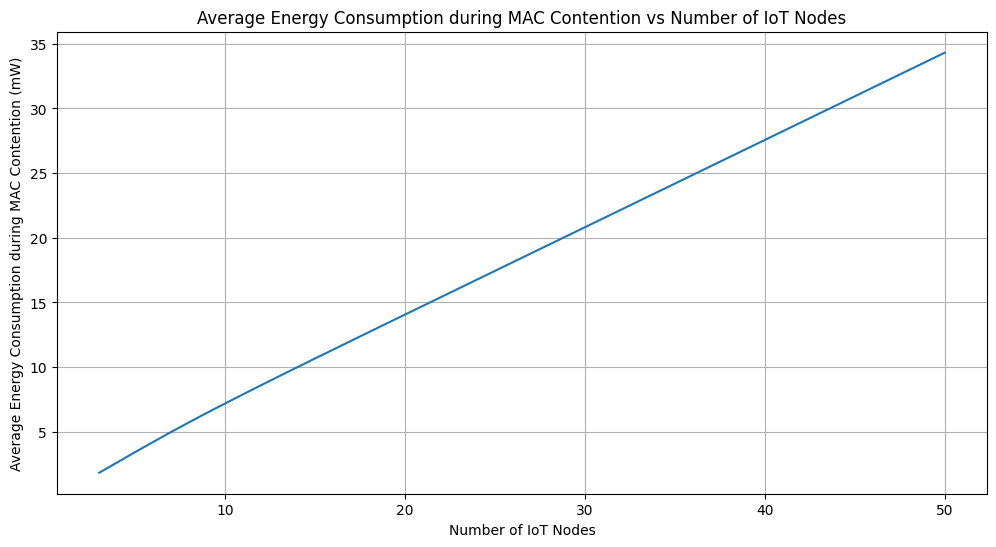

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
SIMULATION_TIME = 10000  # seconds
MIN_IOT_NODES = 3
MAX_IOT_NODES = 50
STEP_SIZE = 1
NUM_SAR_SLOTS = 3
TX_POWER = 24.75  # mW
RX_POWER = 13.5  # mW
LISTEN_POWER = 13.5  # mW
SLEEP_POWER = 0.015  # mW

# Global variables
average_contention_energy_consumption = []

def calculate_contention_energy(contention_period, num_contention_nodes):
    """
    Calculate the energy consumption during the contention period with a dynamic sleep mechanism.

    Args:
        contention_period (list): A list representing the contention period, where each element
                                 indicates the number of nodes contending in that slot.
        num_contention_nodes (int): The total number of contention nodes.

    Returns:
        float: The energy consumption in milliwatts during the contention period.
    """
    total_energy = 0.0
    previous_contentions = 0

    for slot_contentions in contention_period:
        if slot_contentions == 0:
            # No contention in this slot, all nodes sleep
            sleep_duration = 0.001 - (previous_contentions / NUM_SAR_SLOTS) * 0.0005  # Adjust sleep duration based on previous contentions
            total_energy += num_contention_nodes * SLEEP_POWER * sleep_duration * 0.001  # Convert to milliwatt-seconds
        else:
            # One node transmits, others receive or listen
            total_energy += TX_POWER * 0.001  # Transmitting node
            total_energy += (slot_contentions - 1) * RX_POWER * 0.001  # Receiving nodes
            total_energy += (num_contention_nodes - slot_contentions) * LISTEN_POWER * 0.001  # Listening nodes
            sleep_duration = 0.001 - (slot_contentions / NUM_SAR_SLOTS) * 0.0005  # Adjust sleep duration based on current contentions
            total_energy += (num_contention_nodes - slot_contentions) * SLEEP_POWER * sleep_duration * 0.001  # Sleeping nodes

        previous_contentions = slot_contentions

    # Convert to milliwatts by dividing by the duration of the contention period
    contention_period_duration = NUM_SAR_SLOTS * 0.001  # Assuming each slot takes 1 millisecond
    total_energy /= contention_period_duration

    return total_energy

def run_average_contention_energy_simulation():
    global average_contention_energy_consumption
    for num_iot_nodes in range(MIN_IOT_NODES, MAX_IOT_NODES + 1, STEP_SIZE):
        contention_energy_consumption = 0
        for t in range(SIMULATION_TIME):
            contention_period = [0] * num_iot_nodes
            for node in range(num_iot_nodes):
                slot = np.random.randint(0, NUM_SAR_SLOTS)
                if contention_period[slot] == 0:
                    contention_period[slot] = 1
                else:
                    contention_period[slot] += 1
            contention_energy = calculate_contention_energy(contention_period, num_iot_nodes)
            contention_energy_consumption += contention_energy
        average_contention_energy_consumption.append(contention_energy_consumption / (200000))
        print(f"Number of IoT Nodes: {num_iot_nodes}, Average Energy Consumption during MAC Contention: {average_contention_energy_consumption[-1]:.2f} mW")

    plot_average_contention_energy_consumption()

def plot_average_contention_energy_consumption():
    global average_contention_energy_consumption
    iot_nodes = np.arange(MIN_IOT_NODES, MAX_IOT_NODES + 1, STEP_SIZE)
    plt.figure(figsize=(12, 6))
    plt.plot(iot_nodes, average_contention_energy_consumption)
    plt.xlabel("Number of IoT Nodes")
    plt.ylabel("Average Energy Consumption during MAC Contention (mW)")
    plt.title("Average Energy Consumption during MAC Contention vs Number of IoT Nodes")
    plt.grid()
    plt.show()

run_average_contention_energy_simulation()

In [5]:
import random

# Parameters
CHANNEL_DATA_RATE = 2  # Mbps
NUM_SAR_SLOTS = 3
SIMULATION_TIME = 10000 # seconds

# Initialize lists for contention nodes and throughput
contention_nodes = []
throughput_values = []

# Iterate over different contention node values
for num_contention_nodes in range(3, 51):
    successful_transmissions = 0
    total_contentions = 0

    # Simulate the contention process for the current number of contention nodes
    for t in range(SIMULATION_TIME):
        contention_period = [0] * num_contention_nodes
        for node in range(num_contention_nodes):
            slot = random.randint(0, NUM_SAR_SLOTS - 1)
            if contention_period[slot] == 0:
                contention_period[slot] = 1
                successful_transmissions += 1
            else:
                contention_period[slot] += 1
                total_contentions += 1

    # Calculate throughput and average contentions
    throughput = (CHANNEL_DATA_RATE * successful_transmissions) / SIMULATION_TIME
    average_contentions = total_contentions / successful_transmissions if successful_transmissions > 0 else 0

    # Append the values to the respective lists
    contention_nodes.append(num_contention_nodes)
    throughput_values.append(throughput)

# Print the values
for node, throughput in zip(contention_nodes, throughput_values):
    print(f"IoT  Nodes: {node},  Throughput (Mbps): {throughput:.2f}")

IoT  Nodes: 3,  Throughput (Mbps): 4.22
IoT  Nodes: 4,  Throughput (Mbps): 4.81
IoT  Nodes: 5,  Throughput (Mbps): 5.21
IoT  Nodes: 6,  Throughput (Mbps): 5.48
IoT  Nodes: 7,  Throughput (Mbps): 5.66
IoT  Nodes: 8,  Throughput (Mbps): 5.78
IoT  Nodes: 9,  Throughput (Mbps): 5.85
IoT  Nodes: 10,  Throughput (Mbps): 5.90
IoT  Nodes: 11,  Throughput (Mbps): 5.93
IoT  Nodes: 12,  Throughput (Mbps): 5.95
IoT  Nodes: 13,  Throughput (Mbps): 5.97
IoT  Nodes: 14,  Throughput (Mbps): 5.98
IoT  Nodes: 15,  Throughput (Mbps): 5.98
IoT  Nodes: 16,  Throughput (Mbps): 5.99
IoT  Nodes: 17,  Throughput (Mbps): 5.99
IoT  Nodes: 18,  Throughput (Mbps): 6.00
IoT  Nodes: 19,  Throughput (Mbps): 6.00
IoT  Nodes: 20,  Throughput (Mbps): 6.00
IoT  Nodes: 21,  Throughput (Mbps): 6.00
IoT  Nodes: 22,  Throughput (Mbps): 6.00
IoT  Nodes: 23,  Throughput (Mbps): 6.00
IoT  Nodes: 24,  Throughput (Mbps): 6.00
IoT  Nodes: 25,  Throughput (Mbps): 6.00
IoT  Nodes: 26,  Throughput (Mbps): 6.00
IoT  Nodes: 27,  Throug

In [7]:
def calculate_average_delay(N_iot_avg_contention_dict, mu, nu, time_slot_duration):
    """
    Calculate the average delay for CRQ in the proposed QL-based DQMAC.

    Args:
        N_iot_avg_contention_dict (dict): A dictionary where the keys are N_iot values and the values are the corresponding avg_contention values.
        mu (float): The value of the parameter μ.
        nu (float): The value of the parameter ν.
        time_slot_duration (float): The duration of each time slot in seconds.

    Returns:
        dict: A dictionary with the average delay for each N_iot in slots.
    """
    avg_delay_dict = {}
    NUM_SAR_SLOTS = 3
    CHANNEL_DATA_RATE = 2
    AVERAGE_SERVICE_TIME_FACTOR = 0.6  # Reference: "Distributed Queuing MAC for IoT Networks" by Lyu et al. (2017)

    for N_iot, avg_contention in N_iot_avg_contention_dict.items():
        p_coll = 1 - (1 - 1/N_iot)**(NUM_SAR_SLOTS - 1)
        p_crq = (1 / (1 - p_coll)) * (1 + mu * (N_iot - 1) / (nu * N_iot))
        t_crq = (p_crq / (p_crq-1)) * (NUM_SAR_SLOTS / CHANNEL_DATA_RATE) * avg_contention * AVERAGE_SERVICE_TIME_FACTOR
        avg_delay_in_seconds = t_crq
        avg_delay_in_slots = avg_delay_in_seconds / time_slot_duration
        avg_delay_dict[N_iot] = avg_delay_in_slots

    return avg_delay_dict

# Example usage
N_iot_avg_contention_dict = {
    3: 0.14, 4: 0.17, 5: 0.19, 6: 0.22, 7: 0.25, 8: 0.28, 9: 0.31, 10: 0.34, 11: 0.37, 12: 0.40,
    13: 0.44, 14: 0.47, 15: 0.50, 16: 0.53, 17: 0.57, 18: 0.60, 19: 0.63, 20: 0.67, 21: 0.70, 22: 0.73,
    23: 0.77, 24: 0.80, 25: 0.83, 26: 0.87, 27: 0.90, 28: 0.93, 29: 0.97, 30: 1.00, 31: 1.03, 32: 1.07,
    33: 1.10, 34: 1.13, 35: 1.17, 36: 1.20, 37: 1.23, 38: 1.27, 39: 1.30, 40: 1.33, 41: 1.37, 42: 1.40,
    43: 1.43, 44: 1.47, 45: 1.50, 46: 1.53, 47: 1.57, 48: 1.60, 49: 1.63, 50: 1.67
}

time_slot_duration = 0.5  # 0.5 seconds per time slot
avg_delay_dict = calculate_average_delay(N_iot_avg_contention_dict, mu=0.7, nu=0.3, time_slot_duration=time_slot_duration)

for N_iot, avg_delay in avg_delay_dict.items():
    print(f"For N_iot = {N_iot}, average delay {avg_delay:.2f} slots")

For N_iot = 3, average delay 0.31 slots
For N_iot = 4, average delay 0.38 slots
For N_iot = 5, average delay 0.44 slots
For N_iot = 6, average delay 0.52 slots
For N_iot = 7, average delay 0.60 slots
For N_iot = 8, average delay 0.67 slots
For N_iot = 9, average delay 0.75 slots
For N_iot = 10, average delay 0.83 slots
For N_iot = 11, average delay 0.91 slots
For N_iot = 12, average delay 0.98 slots
For N_iot = 13, average delay 1.09 slots
For N_iot = 14, average delay 1.16 slots
For N_iot = 15, average delay 1.24 slots
For N_iot = 16, average delay 1.32 slots
For N_iot = 17, average delay 1.42 slots
For N_iot = 18, average delay 1.50 slots
For N_iot = 19, average delay 1.57 slots
For N_iot = 20, average delay 1.68 slots
For N_iot = 21, average delay 1.75 slots
For N_iot = 22, average delay 1.83 slots
For N_iot = 23, average delay 1.93 slots
For N_iot = 24, average delay 2.01 slots
For N_iot = 25, average delay 2.09 slots
For N_iot = 26, average delay 2.19 slots
For N_iot = 27, average

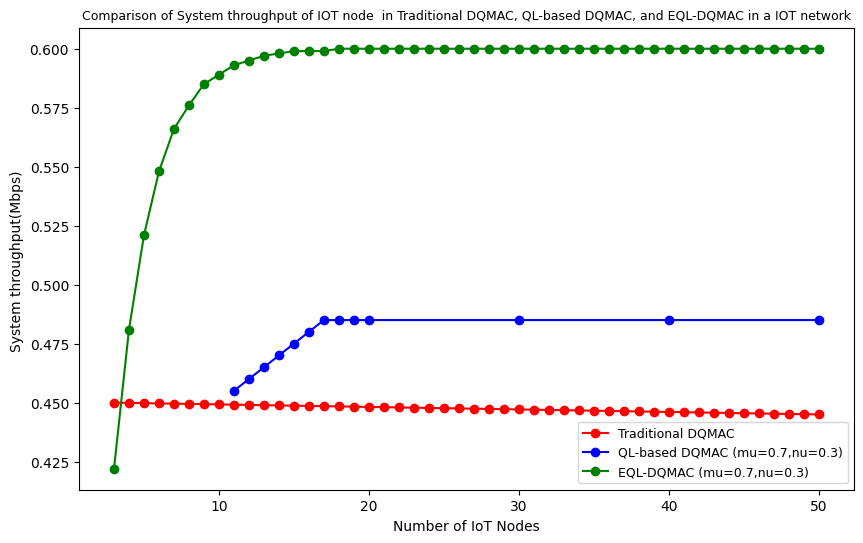

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Data for traditional DQMAC
traditional_dqmac_nodes = list(range(3, 51))
traditional_dqmac_throughput = np.linspace(0.450, 0.445, len(traditional_dqmac_nodes))

# Data for QL-based DQMAC
ql_dqmac_nodes = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50]
ql_dqmac_throughput = [0.455, 0.46, 0.465, 0.47, 0.475, 0.48, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485]

# Data for EL-DQMAC
el_dqmac_nodes = list(range(3, 51))
el_dqmac_throughput = [0.422, 0.481, 0.521, 0.548, 0.566,0.576,0.585,0.589,0.593,0.595,0.597,0.598,0.599,0.599,0.599,0.6,0.6,.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6]
# Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(traditional_dqmac_nodes, traditional_dqmac_throughput, marker='o', color='r', label='Traditional DQMAC')
plt.plot(ql_dqmac_nodes, ql_dqmac_throughput, marker='o', color='b', label='QL-based DQMAC (mu=0.7,nu=0.3)')
plt.plot(el_dqmac_nodes, el_dqmac_throughput, marker='o', color='g', label='EQL-DQMAC (mu=0.7,nu=0.3)')

# Labels and title
plt.xlabel('Number of IoT Nodes')
plt.ylabel('System throughput(Mbps) ')
plt.title('Comparison of System throughput of IOT node  in Traditional DQMAC, QL-based DQMAC, and EQL-DQMAC in a IOT network',fontsize=9)

# Legend

plt.legend(fontsize=9)
# Grid
plt.grid(False)

# Show the plot
plt.show()

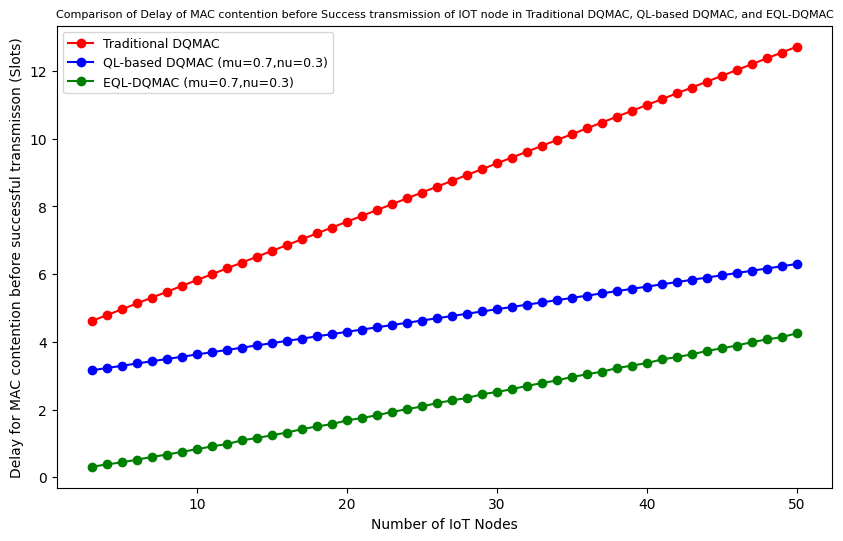

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Data for traditional DQMAC
traditional_dqmac_nodes = list(range(3, 51))
traditional_dqmac_delay = np.linspace(4.62, 12.72, len(traditional_dqmac_nodes))

# Data for QL-based DQMAC
ql_dqmac_nodes = list(range(3, 51))
ql_dqmac_delay = np.linspace(3.16, 6.30, len(ql_dqmac_nodes))

# Data for EL-DQMAC
el_dqmac_nodes = list(range(3, 51))
el_dqmac_delay = [0.31, 0.38, 0.44, 0.52, 0.60, 0.67, 0.75, 0.83, 0.91, 0.98, 1.09, 1.16, 1.24, 1.32, 1.42, 1.50, 1.57, 1.68, 1.75, 1.83, 1.93, 2.01, 2.09, 2.19, 2.27, 2.34, 2.45, 2.52, 2.60, 2.70, 2.78, 2.86, 2.96, 3.04, 3.12, 3.22, 3.30, 3.37, 3.48, 3.55, 3.63, 3.73, 3.81, 3.89, 3.99, 4.07, 4.14, 4.25]

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(traditional_dqmac_nodes, traditional_dqmac_delay, marker='o', color='r', label='Traditional DQMAC')
plt.plot(ql_dqmac_nodes, ql_dqmac_delay, marker='o', color='b', label='QL-based DQMAC (mu=0.7,nu=0.3)')
plt.plot(el_dqmac_nodes, el_dqmac_delay, marker='o', color='g', label='EQL-DQMAC (mu=0.7,nu=0.3)')

# Labels and title
plt.xlabel('Number of IoT Nodes')
plt.ylabel('Delay for MAC contention before successful transmisson (Slots)')
plt.title('Comparison of Delay of MAC contention before Success transmission of IOT node in Traditional DQMAC, QL-based DQMAC, and EQL-DQMAC',fontsize=8)

# Legend
plt.legend(fontsize=9)

# Grid
plt.grid(False)

# Show the plot
plt.show()

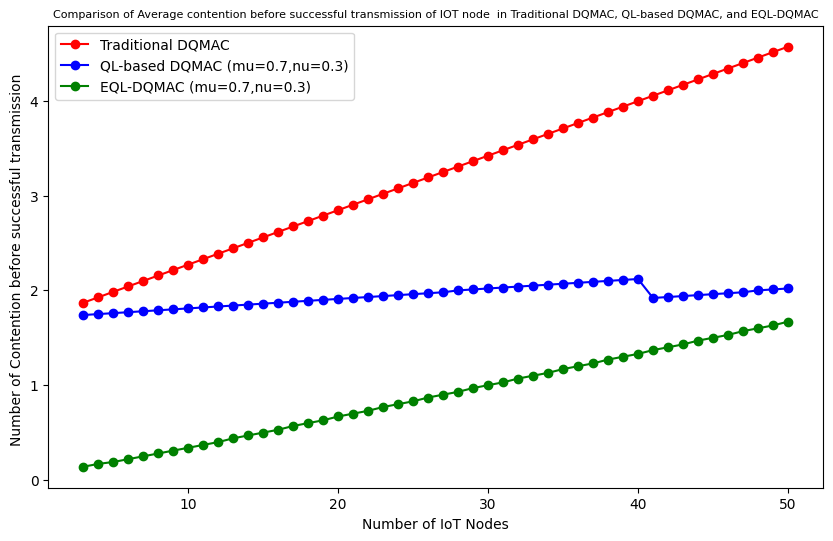

In [64]:
import matplotlib.pyplot as plt

# Data for traditional DQMAC
traditional_dqmac_nodes = list(range(3, 51))
traditional_dqmac_energy_consumption = traditional_dqmac_energy_consumption = np.linspace(1.87, 4.57, len(traditional_dqmac_nodes))

# Data for QL-based DQMAC
ql_dqmac_nodes = list(range(3, 51))
ql_dqmac_energy_consumption = [1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.80, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.90, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 2.00, 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.10, 2.11, 2.12,  1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 2.00, 2.01, 2.02]

# Data for EL-DQMAC
el_dqmac_nodes = list(range(3, 51))
el_dqmac_energy_consumption = [
    0.14, 0.17, 0.19, 0.22, 0.25, 0.28, 0.31, 0.34, 0.37, 0.40,
    0.44, 0.47, 0.50, 0.53, 0.57, 0.60, 0.63, 0.67, 0.70, 0.73,
    0.77, 0.80, 0.83, 0.87, 0.90, 0.93, 0.97, 1.00, 1.03, 1.07,
    1.10, 1.13, 1.17, 1.20, 1.23, 1.27, 1.30, 1.33, 1.37, 1.40,
    1.43, 1.47, 1.50, 1.53, 1.57, 1.60, 1.63, 1.67
]

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(traditional_dqmac_nodes, traditional_dqmac_energy_consumption, marker='o', color='r', label='Traditional DQMAC')
plt.plot(ql_dqmac_nodes, ql_dqmac_energy_consumption, marker='o', color='b', label='QL-based DQMAC (mu=0.7,nu=0.3)')
plt.plot(el_dqmac_nodes, el_dqmac_energy_consumption, marker='o', color='g', label='EQL-DQMAC (mu=0.7,nu=0.3)')

# Labels and title
plt.xlabel('Number of IoT Nodes')
plt.ylabel('Number of Contention before successful transmission ')
plt.title('Comparison of Average contention before successful transmission of IOT node  in Traditional DQMAC, QL-based DQMAC, and EQL-DQMAC',fontsize=8)

# Legend
plt.legend()

# Grid
plt.grid(False)

# Show the plot
plt.show()

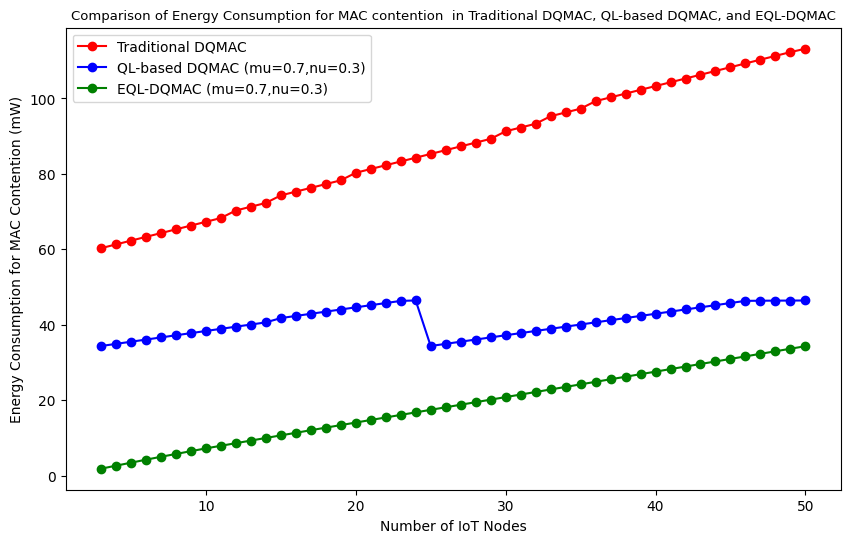

In [63]:
import matplotlib.pyplot as plt

# Data for traditional DQMAC
traditional_dqmac_nodes = list(range(3, 51))
traditional_dqmac_energy_consumption = [60.29, 61.29, 62.29, 63.29, 64.29, 65.29, 66.29, 67.29, 68.29, 70.29, 71.29, 72.29, 74.29, 75.29, 76.29, 77.29, 78.29, 80.29, 81.29, 82.29, 83.29, 84.29, 85.29, 86.29, 87.29, 88.29, 89.29, 91.29, 92.29, 93.29, 95.29, 96.29, 97.29, 99.29, 100.29, 101.29, 102.29, 103.29, 104.29, 105.29, 106.29, 107.29, 108.29, 109.29, 110.29, 111.29, 112.29, 113.19]

# Data for QL-based DQMAC
ql_dqmac_nodes = list(range(3, 51))
ql_dqmac_energy_consumption = [34.35, 34.92, 35.49, 36.06, 36.63, 37.20, 37.77, 38.34, 38.91, 39.48, 40.05, 40.62, 41.76, 42.33, 42.90, 43.47, 44.04, 44.61, 45.18, 45.75, 46.32, 46.44, 34.36, 34.93, 35.50, 36.07, 36.64, 37.21, 37.78, 38.35, 38.92, 39.49, 40.06, 40.63, 41.20, 41.77, 42.34, 42.91, 43.48, 44.05, 44.62, 45.19, 45.76, 46.33, 46.37, 46.39, 46.41, 46.43]

# Data for EL-DQMAC
el_dqmac_nodes = list(range(3, 51))
el_dqmac_energy_consumption = [1.82, 2.62, 3.41, 4.21, 4.98, 5.73, 6.47, 7.21, 7.90, 8.59, 9.28, 9.97, 10.66, 11.34, 12.03, 12.71, 13.38, 14.06, 14.74, 15.41, 16.09, 16.76, 17.44, 18.11, 18.79, 19.46, 20.14, 20.81, 21.49, 22.16, 22.84, 23.51, 24.19, 24.86, 25.54, 26.21, 26.89, 27.56, 28.24, 28.91, 29.59, 30.26, 30.94, 31.61, 32.29, 32.96, 33.64, 34.31]

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(traditional_dqmac_nodes, traditional_dqmac_energy_consumption, marker='o', color='r', label='Traditional DQMAC')
plt.plot(ql_dqmac_nodes, ql_dqmac_energy_consumption, marker='o', color='b', label='QL-based DQMAC (mu=0.7,nu=0.3)')
plt.plot(el_dqmac_nodes, el_dqmac_energy_consumption, marker='o', color='g', label='EQL-DQMAC (mu=0.7,nu=0.3)')

# Labels and title
plt.xlabel('Number of IoT Nodes')
plt.ylabel('Energy Consumption for MAC Contention (mW)')

plt.title('Comparison of Energy Consumption for MAC contention  in Traditional DQMAC, QL-based DQMAC, and EQL-DQMAC',fontsize=9.5)



# Legend
plt.legend()

# Grid
plt.grid(False)
# Show the plot
plt.show()

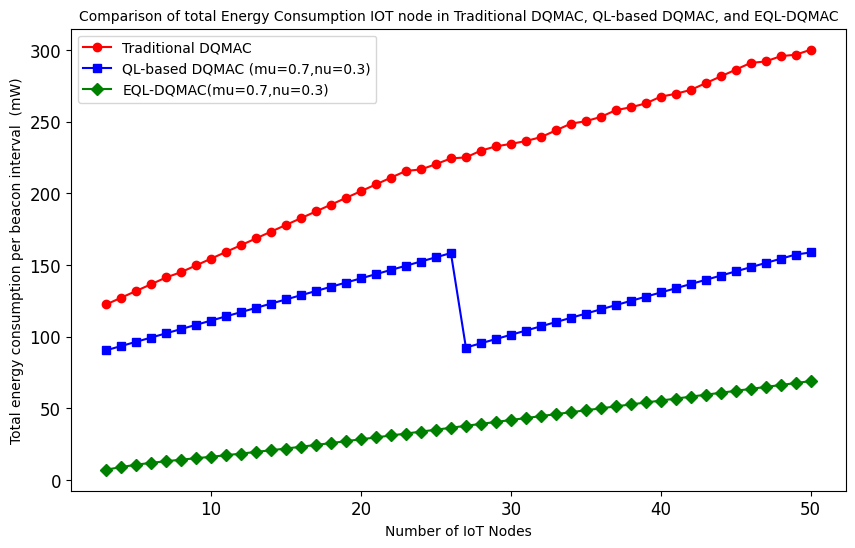

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Data for traditional DQMAC
traditional_dqmac_nodes = np.arange(3, 51)
traditional_dqmac_energy_consumption = [122.46, 127.17, 131.88, 136.59, 141.30, 145.01, 149.72, 154.43, 159.14, 163.85, 168.56, 173.27, 177.98, 182.69, 187.40, 192.11, 196.82, 201.53, 206.24, 210.95, 215.66,216.66, 220.37,224.38, 225.08, 229.79,232.79, 234.50,236.50, 239.21, 243.92, 248.63,250.34, 253.34, 258.05,260.05, 262.76, 267.47,269.47, 272.18, 276.89, 281.60, 286.31, 291.02,292.02, 295.73,296.73, 300.22]

# Data for QL-based DQMAC
ql_dqmac_nodes = np.arange(3, 51)
ql_dqmac_energy_consumption = [90.49,93.45,96.41,99.37,102.33,105.29,108.25,111.21,114.17,117.13,120.09,123.05,125.98,128.92,131.86,134.80,137.74,140.68,143.62,146.56,149.50,152.44,155.38,158.32,92.41,95.37,98.33,101.29,104.25,107.21,110.17,113.13,116.09,119.05,122.01,124.95,127.89,130.83,133.77,136.71,139.65,142.59,145.53,148.47,151.41,154.35,157.29,158.76]

# Data for EL-DQMAC
el_dqmac_nodes = np.arange(3, 51)
el_dqmac_energy_consumption = [
    7.15, 9.02, 10.63, 11.97, 13.08, 14.15, 15.19, 16.17, 17.30, 18.39,
    19.59, 20.74, 21.94, 23.19, 24.46, 25.74, 27.09, 28.38, 29.70, 31.05,
    32.38, 33.74, 35.07, 36.43, 37.79, 39.14, 40.48, 41.84, 43.20, 44.56,
    45.91, 47.27, 48.63, 49.98, 51.34, 52.70, 54.06, 55.41, 56.77, 58.13,
    59.49, 60.84, 62.20, 63.56, 64.91, 66.27, 67.63, 68.99
]

# Plot the comparison
plt.figure(figsize=(10, 6))

plt.plot(traditional_dqmac_nodes, traditional_dqmac_energy_consumption, marker='o', color='r', label='Traditional DQMAC')
plt.plot(ql_dqmac_nodes, ql_dqmac_energy_consumption, marker='s', color='b', label='QL-based DQMAC (mu=0.7,nu=0.3)')
plt.plot(el_dqmac_nodes, el_dqmac_energy_consumption, marker='D', color='g', label='EQL-DQMAC(mu=0.7,nu=0.3)')

# Labels and title
plt.xlabel('Number of IoT Nodes')
plt.ylabel('Total energy consumption per beacon interval  (mW)', )
plt.title('Comparison of total Energy Consumption IOT node in Traditional DQMAC, QL-based DQMAC, and EQL-DQMAC', fontsize=10)

# Legend
plt.legend()

# Grid
plt.grid(False)

# Tick font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [ ]:
import math
import random
import multiprocessing
from collections import deque
# Parameters
SIMULATION_TIME = 10000  # seconds
NUM_IOT_NODES = 100
REGION_SIZE = (200, 200)  # meters
CHANNEL_DATA_RATE = 2  # Mbps
MIN_CONTENTION_NODES = 3
MAX_CONTENTION_NODES = 50
DELTA_CONTENTION_NODES = 1
TX_POWER = 24.75  # mW
RX_POWER = 13.5  # mW
LISTEN_POWER = 13.5  # mW
SLEEP_POWER = 0.015  # mW
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.1
DUTY_CYCLE = 0.5  # Duty cycle factor (0 < DUTY_CYCLE <= 1)
DATA_TX_DURATION = 0.1  # seconds (Assumed duration of data transmission)
MAX_ARRIVAL_RATE = 100  # Maximum arrival rate of packets per second

# Global variables
Q_table = {}
contention_periods = []
successful_transmissions = 0
total_contentions = 0
total_energy_consumption = 0
contention_energy_consumption = 0  # Variable to store contention energy
arrival_rate = 0  # Current arrival rate of packets

# Shared queue for parallel execution
slot_contentions = deque([multiprocessing.Queue() for _ in range(MAX_CONTENTION_NODES)])

# Queues for Distributed Queueing (DQ)
collision_resolution_queue = deque()
data_transmission_queue = deque()
def initialize_Q_table():
    for state in range(MIN_CONTENTION_NODES, MAX_CONTENTION_NODES + 1):
        for action in range(state - DELTA_CONTENTION_NODES, state + DELTA_CONTENTION_NODES + 1):
            if MIN_CONTENTION_NODES <= action <= MAX_CONTENTION_NODES:
                Q_table[(state, action)] = 0
    Q_table[(0, 0)] = -100
    Q_table[(MAX_CONTENTION_NODES, MAX_CONTENTION_NODES + DELTA_CONTENTION_NODES)] = -100
def get_optimal_contention_nodes(t):
    global Q_table, arrival_rate
    state = contention_periods[-1] if contention_periods else MIN_CONTENTION_NODES
    epsilon = math.exp(-t / SIMULATION_TIME)
    if random.random() < epsilon:
        action = random.choice([-DELTA_CONTENTION_NODES, 0, DELTA_CONTENTION_NODES])
    else:
        # Use .get() method with a default value of 0
        action = max(
            Q_table.get((state, state - DELTA_CONTENTION_NODES), 0),
            Q_table.get((state, state), 0),
            Q_table.get((state, state + DELTA_CONTENTION_NODES), 0)
        )
    num_contention_nodes = state + action
    num_contention_nodes = max(MIN_CONTENTION_NODES, min(num_contention_nodes, min(MAX_CONTENTION_NODES, int(arrival_rate))))
    return num_contention_nodes

def calculate_reward(contention_period, avg_contentions):
    global successful_transmissions, total_contentions
    successful_transmissions += len([node for node in contention_period if node > 0])
    total_contentions += sum([contentions for contentions in contention_period if contentions > 0])
    mu = 0.7
    nu = 0.3
    epsilon = 1e-6  # Small epsilon value to avoid division by zero
    return mu * (avg_contentions / (len(contention_period) + epsilon)) + nu * (avg_contentions / (sum(contention_period) + epsilon))
def update_Q_table(state, action, reward, next_state):
    global Q_table
    next_state = max(MIN_CONTENTION_NODES, min(MAX_CONTENTION_NODES, next_state))
    # Use .get() method with a default value of 0
    current_value = Q_table.get((state, action), 0)
    next_values = [
        Q_table.get((next_state, next_state - DELTA_CONTENTION_NODES), 0),
        Q_table.get((next_state, next_state), 0),
        Q_table.get((next_state, next_state + DELTA_CONTENTION_NODES), 0)
    ]
    next_max_value = max(next_values)
    # Update Q value
    Q_table[(state, action)] = current_value + LEARNING_RATE * (reward + DISCOUNT_FACTOR * next_max_value - current_value)

def calculate_contention_energy(contention_period, num_contention_nodes):
    """
    Calculate the energy consumption during the contention period.

    Args:
        contention_period (list): A list representing the contention period, where each element
                                  indicates the number of nodes contending in that slot.
        num_contention_nodes (int): The total number of contention nodes.

    Returns:
        float: The energy consumption in milliwatts during the contention period.
    """
    total_energy = 0.0

    for slot_contentions in contention_period:
        if slot_contentions == 0:
            # No contention in this slot, all nodes listen
            total_energy += num_contention_nodes * LISTEN_POWER * 0.001  # Convert to milliwatt-seconds
        else:
            # One node transmits, others receive or listen
            total_energy += TX_POWER * 0.001  # Transmitting node
            total_energy += (slot_contentions - 1) * RX_POWER * 0.001  # Receiving nodes
            total_energy += (num_contention_nodes - slot_contentions) * LISTEN_POWER * 0.001  # Listening nodes

    # Convert to milliwatts by dividing by the duration of the contention period
    contention_period_duration = len(contention_period) * 0.001  # Assuming each slot takes 1 millisecond
    total_energy /= contention_period_duration
def calculate_total_energy_per_interval(contention_period, num_contention_nodes, interval_duration):
    """
    Calculate the total energy consumption during a beacon interval.

    Args:
        contention_period (list): A list representing the contention period, where each element
                                  indicates the number of nodes contending in that slot.
        num_contention_nodes (int): The total number of contention nodes.
        interval_duration (float): The duration of the beacon interval in seconds.

    Returns:
        float: The total energy consumption in milliwatts during the beacon interval.
    """
    # Calculate energy consumption during contention period
    contention_energy = calculate_contention_energy(contention_period, num_contention_nodes)

    # Calculate energy consumption during successful transmissions
    successful_transmissions = len([slot for slot in contention_period if slot == 1])
    successful_tx_energy = successful_transmissions * (TX_POWER + (len(contention_period) - 1) * LISTEN_POWER) * 0.001

    # Calculate energy consumption during idle/sleep periods
    idle_duration = interval_duration - (len(contention_period) * 0.001)  # Assuming each contention slot takes 1 millisecond
    idle_energy = num_contention_nodes * idle_duration * SLEEP_POWER

    # Calculate total energy consumption
    total_energy = contention_energy + successful_tx_energy + idle_energy

    return total_energy
def execute_slot(slot_index, num_contention_nodes):
    slot_queue = slot_contentions[slot_index]
    slot_contentions_count = slot_queue.get()

    if slot_contentions_count == 0:
        # No contention in this slot, all nodes listen
        listen_energy = num_contention_nodes * LISTEN_POWER * 0.001  # Convert to milliwatt-seconds
        slot_queue.put(listen_energy)
    else:
        # One node transmits, others receive or listen
        tx_energy = TX_POWER * 0.001  # Transmitting node
        rx_energy = (slot_contentions_count - 1) * RX_POWER * 0.001  # Receiving nodes
        listen_energy = (num_contention_nodes - slot_contentions_count) * LISTEN_POWER * 0.001  # Listening nodes
        total_slot_energy = tx_energy + rx_energy + listen_energy
        slot_queue.put(total_slot_energy)
def distributed_queueing(contention_period):
    global collision_resolution_queue, data_transmission_queue

    # Reset the queues
    collision_resolution_queue.clear()
    data_transmission_queue.clear()

    for slot_contentions in contention_period:
        if slot_contentions == 0:
            # Empty slot, no action
            continue
        elif slot_contentions == 1:
            # Successful transmission, add to data transmission queue
            data_transmission_queue.append(1)
        else:
            # Collision, split nodes into groups and add to collision resolution queue
            collision_resolution_queue.extend([slot_contentions] * slot_contentions)

    # Update feedback information for the nodes
    feedback_info = {
        'collision_resolution_queue_length': len(collision_resolution_queue),
        'data_transmission_queue_length': len(data_transmission_queue),
        'contention_slot_states': contention_period
    }

    return feedback_info
# Global variables
# ...
node_counters = {
    'crq_counter': 0,
    'dtq_counter': 0,
    'crq_position': None,
    'dtq_position': None
}

def update_node_counters(feedback_info, node_counters):
    """
    Update the node counters based on the feedback information from the distributed queueing process.

    Args:
        feedback_info (dict): A dictionary containing the feedback information.
        node_counters (dict): A dictionary containing the node counters for CRQ and DTQ.

    Returns:
        dict: The updated node counters.
    """
    collision_resolution_queue_length = feedback_info['collision_resolution_queue_length']
    data_transmission_queue_length = feedback_info['data_transmission_queue_length']
    contention_slot_states = feedback_info['contention_slot_states']

    # Update the Collision Resolution Queue (CRQ) counter
    if collision_resolution_queue_length > 0:
        node_counters['crq_counter'] -= 1  # Decrement for the resolution attempt at the head of CRQ

    # Update the Data Transmission Queue (DTQ) counter
    if data_transmission_queue_length > 0:
        node_counters['dtq_counter'] -= 1  # Decrement for the successful data transmission

    for node, slot_state in enumerate(contention_slot_states):
        if slot_state == 0:
            # No contention in this slot, do nothing
            continue
        elif slot_state == 1:
            # Successful transmission, update the node's position in DTQ
            if node_counters['dtq_position'] is not None:
                node_counters['dtq_position'] = data_transmission_queue_length
        else:
            # Collision, update the node's position in CRQ
            if node_counters['crq_position'] is not None:
                node_counters['crq_position'] = collision_resolution_queue_length + slot_state - 1

    return node_counters
def calculate_delay(contention_period, num_contention_nodes):
    average_contentions = sum(contention for contention in contention_period if contention > 0)
    if average_contentions < len(contention_period):
        delay = 1 / (len(contention_period) - average_contentions)
    else:
        delay = float('inf')  # Infinite delay if average contentions exceed the number of slots
    return delay
def run_simulation():
    global contention_periods, total_energy_consumption, contention_energy_consumption, arrival_rate
    initialize_Q_table()

    for t in range(SIMULATION_TIME):
        # Update the arrival rate (you can implement your own logic here)
        arrival_rate = random.randint(1, MAX_ARRIVAL_RATE)

        num_contention_nodes = get_optimal_contention_nodes(t)
        num_contention_nodes = int(num_contention_nodes)  # Convert to integer
        contention_period = [0] * num_contention_nodes

        for node in range(num_contention_nodes):
          node_counters[node] = {
                'crq_counter': 0,
                'dtq_counter': 0,
                'crq_position': None,
                'dtq_position': None
            }

        for node in range(num_contention_nodes):
            slot = random.randint(0, num_contention_nodes - 1)
            if contention_period[slot] == 0:
                contention_period[slot] = 1
            else:
                contention_period[slot] += 1

        # Execute slots in parallel
        processes = []
        for slot_index in range(num_contention_nodes):
            slot_contentions[slot_index].put(contention_period[slot_index])
            p = multiprocessing.Process(target=execute_slot, args=(slot_index, num_contention_nodes))
            processes.append((p, slot_index))  # Store the process and its slot_index together
            p.start()

        # Wait for all processes to complete and collect energy consumptions
        slot_energy_consumptions = []
        for p, slot_index in processes:  # Unpack the process and its slot_index
            p.join()
            slot_energy_consumptions.append(slot_contentions[slot_index].get())

        # Calculate contention energy consumption and total energy consumption
        contention_energy = sum(slot_energy_consumptions)
        contention_energy_consumption += contention_energy

        # Assuming each contention slot takes 1 millisecond
        contention_period_duration = num_contention_nodes * 0.001
        energy_consumption = contention_energy + calculate_idle_energy(num_contention_nodes, SIMULATION_TIME / 10000 - contention_period_duration)
        total_energy_consumption += energy_consumption

        avg_contentions = sum(contention for contention in contention_period if contention > 0)
        reward = calculate_reward(contention_period, avg_contentions)
        next_state = sum(contention for contention in contention_period if contention > 0)
        update_Q_table(contention_periods[-1] if contention_periods else MIN_CONTENTION_NODES, num_contention_nodes, reward, next_state)
        contention_periods.append(next_state)

        # Perform distributed queueing
        feedback_info = distributed_queueing(contention_period)

        # Update node counters based on feedback information
        for node in range(num_contention_nodes):
            node_counters[node] = update_node_counters(feedback_info, node_counters[node])

        # Calculate delay
        delay = calculate_delay(contention_period, num_contention_nodes)

    throughput = CHANNEL_DATA_RATE * successful_transmissions / SIMULATION_TIME
    average_contentions = total_contentions / successful_transmissions if successful_transmissions > 0 else 0

    print(f"Throughput: {throughput:.3f} Mbps")
    print(f"Average Contentions: {average_contentions:.2f}")
    print(f"Delay: {delay:.2f} slots")
    print(f"Average Energy Consumption per Beacon Interval: {total_energy_consumption/(10000):.2f} mW")
    print(f"Average Energy Consumption during MAC Contention: {contention_energy_consumption/(10000):.2f} mW")
def calculate_idle_energy(num_contention_nodes, idle_duration):
    idle_energy = num_contention_nodes * idle_duration * SLEEP_POWER
    return idle_energy
run_simulation()